[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/CorrectedBinaryCubes.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [5]:
# Installs
!pip install -U -q PyDrive

In [6]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback, LearningRateScheduler
import keras.backend as K
import keras.utils as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import re
from io import StringIO
from math import exp

Using TensorFlow backend.


In [7]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [8]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [4]:
print(categories_dict)

{'grass_flat': 0, 'grass_rough': 1, 'cubes': 2, 'black_rough': 3, 'flat': 4, 'black_flat': 5}


# Utils
Helper functions.

In [3]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [4]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

# Model
Recurrent Neural Network model in Keras.

In [9]:
def get_model1():
  model = Sequential()
  model.add(LSTM(32, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [10]:
def get_model2():
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [11]:
def get_model3():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(32))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [12]:
def get_model4():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [13]:
def get_model5():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [14]:
def get_model6():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [15]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('cubes')==0 or pow_file[0].find('flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [0]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('black_rough')==0 or pow_file[0].find('grass_rough')==0 \
     or pow_file[0].find('black_flat')==0 or pow_file[0].find('grass_flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [16]:
# Split the biggest examples into separate sequences
max_length = 100
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 150
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [17]:
print(examples_categories)
print(categories_dict)

{0: 0, 1: 144, 2: 0, 3: 0, 4: 150, 5: 0}
{'grass_flat': 0, 'flat': 1, 'black_flat': 2, 'black_rough': 3, 'cubes': 4, 'grass_rough': 5}


In [18]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]

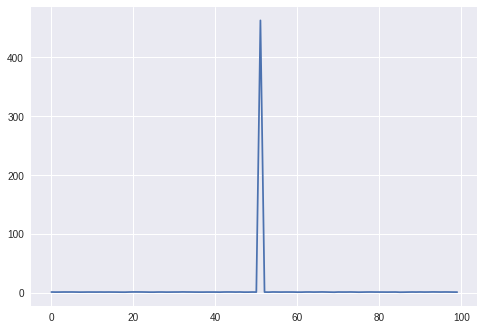

In [19]:
plt.plot(currents_no_labels[0])

In [20]:
# Skip some timesteps
skip = 1
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [21]:
# Get training data into a numpy matrix
full_x = np.stack(currents_skip, axis=0)
# Get training labels
full_y = np.array([currents[1] for currents in currents_long])

In [22]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [23]:
#full_x_norm = utils.normalize(full_x, axis=0, order=2)
x_shuffled, y_shuffled = unison_shuffled_copies(full_x, full_y)

In [24]:
full_y_labels = [from_one_hot(one_hot) for one_hot in y_shuffled]
full_y_binary = [0 if label==categories_dict['cubes'] else 1 for label in full_y_labels]

#full_y_binary = [0 if label==categories_dict['black_flat'] or label==categories_dict['black_rough'] else 1 for label in full_y_labels]

In [25]:
print(full_y_binary)

[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]


[0. 1. 0. 0. 0. 0.]


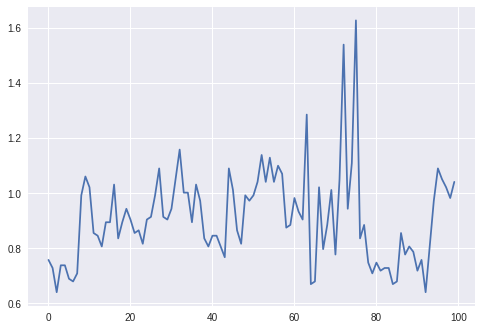

In [26]:
# Training set
train_x = x_shuffled[50:]
train_y = full_y_binary[50:]
# Test set
test_x = x_shuffled[:50]
test_y = full_y_binary[:50]

plt.plot(x_shuffled[1])
print(full_y[1])

# Experiment

In [75]:
model = get_model6()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 64)           16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [76]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [77]:
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
callbacks_list = [lrate]

In [78]:
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [0]:
history = model.fit(train_x, train_y, epochs=500, batch_size=16, shuffle=True)

Epoch 1/500
241/241 [==============================] - 5s 20ms/step - loss: 0.6942 - acc: 0.4979
Epoch 2/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6924 - acc: 0.5270
Epoch 3/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6891 - acc: 0.4689
Epoch 4/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6804 - acc: 0.5270
Epoch 5/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6821 - acc: 0.5726
Epoch 6/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6738 - acc: 0.5643
Epoch 7/500
241/241 [==============================] - 3s 11ms/step - loss: 0.7209 - acc: 0.6100
Epoch 8/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6319 - acc: 0.6307
Epoch 9/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6176 - acc: 0.6100
Epoch 10/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6245 - acc: 0.6432
Epoch 11/500
144/241 [=======

241/241 [==============================] - 3s 11ms/step - loss: 0.6181 - acc: 0.6141
Epoch 12/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6087 - acc: 0.6473
Epoch 13/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6149 - acc: 0.6349
Epoch 14/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6092 - acc: 0.6805
Epoch 15/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6430 - acc: 0.6556
Epoch 16/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5971 - acc: 0.6432
Epoch 17/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6199 - acc: 0.6805
Epoch 18/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5997 - acc: 0.6639
Epoch 19/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6035 - acc: 0.6515
Epoch 20/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5595 - acc: 0.6680
Epoch 21/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.8256 - acc: 0.5851
Epoch 22/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6172 - acc: 0.5851
Epoch 23/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6264 - acc: 0.5934
Epoch 24/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6112 - acc: 0.6224
Epoch 25/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6093 - acc: 0.6390
Epoch 26/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5981 - acc: 0.6598
Epoch 27/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5926 - acc: 0.6639
Epoch 28/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5898 - acc: 0.7095
Epoch 29/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5609 - acc: 0.7344
Epoch 30/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5682 - acc: 0.7095
Epoch 31/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5940 - acc: 0.6515
Epoch 32/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5933 - acc: 0.6680
Epoch 33/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5833 - acc: 0.6598
Epoch 34/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5744 - acc: 0.6929
Epoch 35/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5468 - acc: 0.6805
Epoch 36/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5485 - acc: 0.7137
Epoch 37/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5371 - acc: 0.7427
Epoch 38/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5533 - acc: 0.6846
Epoch 39/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5472 - acc: 0.7137
Epoch 40/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5194 - acc: 0.7386
Epoch 41/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5185 - acc: 0.7427
Epoch 42/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5249 - acc: 0.7054
Epoch 43/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5194 - acc: 0.6888
Epoch 44/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5223 - acc: 0.7178
Epoch 45/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5476 - acc: 0.6971
Epoch 46/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4994 - acc: 0.7303
Epoch 47/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5470 - acc: 0.6888
Epoch 48/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5051 - acc: 0.7386
Epoch 49/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5013 - acc: 0.7427
Epoch 50/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5210 - acc: 0.7427
Epoch 51/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5386 - acc: 0.7344
Epoch 52/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4953 - acc: 0.7718
Epoch 53/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5169 - acc: 0.7095
Epoch 54/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5497 - acc: 0.6846
Epoch 55/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4953 - acc: 0.7635
Epoch 56/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5327 - acc: 0.7552
Epoch 57/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5105 - acc: 0.7344
Epoch 58/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5085 - acc: 0.7178
Epoch 59/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5147 - acc: 0.7510
Epoch 60/500
241/241 [==============================] - 3s 11ms/step - loss: 0.6822 - acc: 0.6971
Epoch 61/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5052 - acc: 0.7220
Epoch 62/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5653 - acc: 0.7137
Epoch 63/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5522 - acc: 0.7178
Epoch 64/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5072 - acc: 0.7344
Epoch 65/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4772 - acc: 0.7635
Epoch 66/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5376 - acc: 0.7427
Epoch 67/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4994 - acc: 0.7510
Epoch 68/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5001 - acc: 0.7552
Epoch 69/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4994 - acc: 0.7552
Epoch 70/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5153 - acc: 0.7303
Epoch 71/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.4831 - acc: 0.7718
Epoch 72/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5242 - acc: 0.7261
Epoch 73/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4878 - acc: 0.7303
Epoch 74/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5094 - acc: 0.7303
Epoch 75/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5079 - acc: 0.7427
Epoch 76/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4787 - acc: 0.7593
Epoch 77/500
241/241 [==============================] - 3s 11ms/step - loss: 0.8720 - acc: 0.6805
Epoch 78/500
241/241 [==============================] - 3s 11ms/step - loss: 0.8253 - acc: 0.6515
Epoch 79/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5707 - acc: 0.6846
Epoch 80/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5333 - acc: 0.7469
Epoch 81/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5125 - acc: 0.7344
Epoch 82/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4976 - acc: 0.7510
Epoch 83/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5616 - acc: 0.6929
Epoch 84/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5073 - acc: 0.7220
Epoch 85/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4793 - acc: 0.7469
Epoch 86/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4843 - acc: 0.7386
Epoch 87/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4916 - acc: 0.7386
Epoch 88/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5458 - acc: 0.7303
Epoch 89/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4642 - acc: 0.7884
Epoch 90/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5147 - acc: 0.7386
Epoch 91/500
176/241 [===========

241/241 [==============================] - 3s 11ms/step - loss: 0.5335 - acc: 0.7510
Epoch 92/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5121 - acc: 0.7386
Epoch 93/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4764 - acc: 0.7635
Epoch 94/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4763 - acc: 0.7718
Epoch 95/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4915 - acc: 0.7593
Epoch 96/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4693 - acc: 0.7842
Epoch 97/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5652 - acc: 0.6888
Epoch 98/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4800 - acc: 0.7510
Epoch 99/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4990 - acc: 0.7469
Epoch 100/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4763 - acc: 0.7635
Epoch 101/500
176/241 [=========

241/241 [==============================] - 3s 11ms/step - loss: 0.4866 - acc: 0.7676
Epoch 102/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4537 - acc: 0.7759
Epoch 103/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4730 - acc: 0.7884
Epoch 104/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5582 - acc: 0.7427
Epoch 105/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4870 - acc: 0.7676
Epoch 106/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5114 - acc: 0.7469
Epoch 107/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4701 - acc: 0.7801
Epoch 108/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5036 - acc: 0.7427
Epoch 109/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4818 - acc: 0.7676
Epoch 110/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4788 - acc: 0.7552
Epoch 111/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.5205 - acc: 0.7718
Epoch 112/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4715 - acc: 0.7552
Epoch 113/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4783 - acc: 0.7593
Epoch 114/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4859 - acc: 0.7552
Epoch 115/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5111 - acc: 0.7593
Epoch 116/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4748 - acc: 0.7552
Epoch 117/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4434 - acc: 0.8008
Epoch 118/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5212 - acc: 0.7635
Epoch 119/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4892 - acc: 0.7427
Epoch 120/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4845 - acc: 0.7676
Epoch 121/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.5619 - acc: 0.6722
Epoch 122/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5185 - acc: 0.7427
Epoch 123/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4804 - acc: 0.7884
Epoch 124/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5778 - acc: 0.7261
Epoch 125/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4462 - acc: 0.7925
Epoch 126/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5173 - acc: 0.7261
Epoch 127/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4782 - acc: 0.7593
Epoch 128/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4576 - acc: 0.7552
Epoch 129/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5085 - acc: 0.7718
Epoch 130/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4524 - acc: 0.7676
Epoch 131/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4566 - acc: 0.7967
Epoch 132/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4285 - acc: 0.7759
Epoch 133/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4853 - acc: 0.7759
Epoch 134/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5307 - acc: 0.6971
Epoch 135/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4142 - acc: 0.8050
Epoch 136/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4515 - acc: 0.7967
Epoch 137/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5079 - acc: 0.7303
Epoch 138/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4781 - acc: 0.7718
Epoch 139/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4821 - acc: 0.7801
Epoch 140/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4001 - acc: 0.8257
Epoch 141/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4806 - acc: 0.7469
Epoch 142/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4804 - acc: 0.7676
Epoch 143/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4554 - acc: 0.7884
Epoch 144/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4804 - acc: 0.7344
Epoch 145/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4174 - acc: 0.7842
Epoch 146/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4296 - acc: 0.8050
Epoch 147/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4587 - acc: 0.7510
Epoch 148/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5070 - acc: 0.7759
Epoch 149/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4167 - acc: 0.7967
Epoch 150/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4629 - acc: 0.7469
Epoch 151/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4645 - acc: 0.7801
Epoch 152/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5656 - acc: 0.7635
Epoch 153/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4179 - acc: 0.7967
Epoch 154/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4295 - acc: 0.8008
Epoch 155/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4638 - acc: 0.7635
Epoch 156/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4199 - acc: 0.8008
Epoch 157/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4162 - acc: 0.8216
Epoch 158/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4461 - acc: 0.7676
Epoch 159/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4501 - acc: 0.7801
Epoch 160/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4359 - acc: 0.7884
Epoch 161/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4435 - acc: 0.8050
Epoch 162/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4332 - acc: 0.7925
Epoch 163/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4567 - acc: 0.7635
Epoch 164/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4203 - acc: 0.7925
Epoch 165/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4462 - acc: 0.7759
Epoch 166/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4271 - acc: 0.7967
Epoch 167/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5047 - acc: 0.7884
Epoch 168/500
241/241 [==============================] - 3s 11ms/step - loss: 0.7427 - acc: 0.6805
Epoch 169/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4528 - acc: 0.7884
Epoch 170/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4693 - acc: 0.7593
Epoch 171/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.5004 - acc: 0.7220
Epoch 172/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4359 - acc: 0.7635
Epoch 173/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4133 - acc: 0.7925
Epoch 174/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4145 - acc: 0.7884
Epoch 175/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4359 - acc: 0.7759
Epoch 176/500
241/241 [==============================] - 3s 11ms/step - loss: 0.5477 - acc: 0.7137
Epoch 177/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4712 - acc: 0.7593
Epoch 178/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4049 - acc: 0.8216
Epoch 179/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4178 - acc: 0.7967
Epoch 180/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4257 - acc: 0.7759
Epoch 181/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4281 - acc: 0.7759
Epoch 182/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4562 - acc: 0.7967
Epoch 183/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4357 - acc: 0.7676
Epoch 184/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4256 - acc: 0.8091
Epoch 185/500
241/241 [==============================] - 3s 11ms/step - loss: 0.3895 - acc: 0.8299
Epoch 186/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4254 - acc: 0.8008
Epoch 187/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4600 - acc: 0.7884
Epoch 188/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4431 - acc: 0.7925
Epoch 189/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4422 - acc: 0.7925
Epoch 190/500
241/241 [==============================] - 3s 11ms/step - loss: 0.4184 - acc: 0.8008
Epoch 191/500
160/241 [=

241/241 [==============================] - 3s 11ms/step - loss: 0.4374 - acc: 0.7967
Epoch 192/500
192/241 [======================>.......] - ETA: 0s - loss: 0.4478 - acc: 0.8021

Text(0.5,0,'epoch')

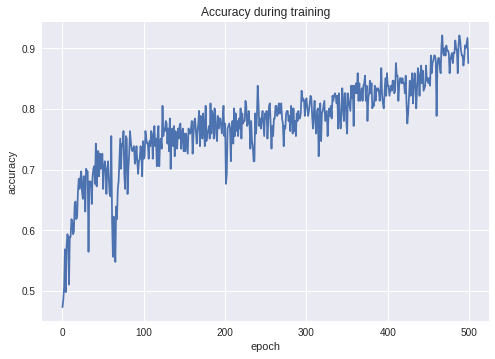

In [72]:
# Plot the accuracy during training
plt.plot(history.history['acc'])
plt.title("Accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")

Text(0.5,0,'epoch')

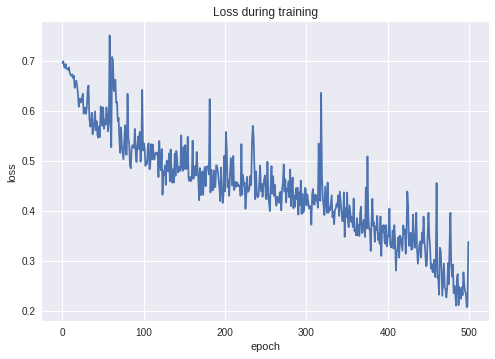

In [73]:
plt.plot(history.history['loss'])
plt.title("Loss during training")
plt.ylabel("loss")
plt.xlabel("epoch")

In [74]:
# Evalute the same model
model.evaluate(x=test_x, y=test_y)


50/50 [==============================] - 1s 11ms/step


[0.4583666813373566, 0.7800000023841858]